# WRITING YOUR OWN CUSTOM LOSSES

**Author** - [Avik Pal](https://avik-pal.github.io) &  [Aniket Das](https://aniket1998.github.io)

**TorchGAN** is designed keeping a high degree of extensibility in mind, and allows you to write custom loss functions of your own without having to rewrite the entire training and evaluation loop. This can be done by extending the ```torchgan.losses.GeneratorLoss``` or the ```torchgan.losses.DiscriminatorLoss``` object. 

All **TorchGAN** losses have a ```train_ops``` associated with it that dictates what steps are to be followed for the loss to be computed and backpropagated. By default, most of the ```train_ops``` follow a **Two Timescale Update Rule (TTUR) ** as follows

1. Sample a noise vector from a Normal Distribution $z \sim \mathcal{N}(0,\,1)$
3. $d_{real} = D(x)$
4. $d_{fake} = D(G(z))$
5. $\mathcal{L} = Loss(d_{real}, d_{fake})$  (*for a Generator Loss $d_{real}$ is generally not computed*)
6. Backpropagate over $\mathcal{L}$

Where 
* $x$ is a sample from the Data Distribution
* $D$ is the Discriminator Network
* $G$ is the Generator Network

Simple losses that conform to this kind of an update rule can be easily implemented by overriding the ```forward``` method of the ```GeneratorLoss``` or ```DiscriminatorLoss``` object

** *NB: It is highly recommended that you go over the Introduction to TorchGAN Tutorial before reading this* *

## WRITING CUSTOM LOSSES THAT FOLLOW THE STANDARD UPDATE RULE

We shall demonstrate this by implementing the [Boundary Seeking GAN by Hjelm et. al.](https://arxiv.org/abs/1702.08431), also known as BGAN
BGAN involves a departure from the Minimax Loss by changing the Generator Loss term in the following manner

$$ \mathcal{L_{generator}} = \frac{1}{2}E_{z \sim p(z)}[(log(D(G(z))) - log(1 - D(G(z))))^2]$$

where

* $z$ is the noise sampled from a probability distribution
* $D$ is the Discriminator Network
* $G$ is the Generator Network

We can observe that the update rule for such a loss confirms with the Standard Update Rule used in **TorchGAN**, hence this loss can be implemented simply by extending the ```torchgan.losses.GeneratorLoss``` object and overriding the ```forward``` method

In [1]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import numpy as np
# Pytorch and Torchvision Imports
import torch
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
import torchgan
from torchgan.models import DCGANGenerator, DCGANDiscriminator
from torchgan.losses import GeneratorLoss, MinimaxDiscriminatorLoss
from torchgan.trainer import Trainer

In [2]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## LOADING THE DATASET

We make the following transforms before feeding the **MNIST Dataset** into the networks

1. The default size of MNIST is $1 \times 28 \times 28$. However, by convention, the default input size in **torchgan.models** is a power of 2 and at least 16. Hence we shall be resizing the images to $1 \times 32 \times 32$.  One can also **zero-pad** the boundary, without any noticeable difference 

2. The output quality of GANs is improved when the images are constrained in the range The images are normalized with a mean and standard deviation of **0.5** , thereby constraining most of the inputs in the range (-1, 1)

Finally the **torchgan.trainer.Trainer** needs a **DataLoader** as input. So we are going to construct a DataLoader for the MNIST Dataset.

In [3]:
dataset = dsets.MNIST(root="./mnist", train=True, download=True,
                      transform=transforms.Compose([transforms.Resize((32, 32)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=(0.5,),
                                                                         std=(0.5,))]))

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=512, num_workers=8)

## DEFINING THE BOUNDARY SEEKING LOSS

As discussed above, the Boundary Seeking Loss is implementing by overriding the ```forward``` pass of the Generator Loss without requiring any modifications to the ```train_ops```. 

The ```forward``` method receives the object $d_{fake} = D(G(z))$ as a parameter, where $G$ is the Generator Network, $D$ is the Discriminator Network and $z$ is a sample from the Noise Prior.


*NB: This example shall be using the standard DCGAN Generator and Discriminator available in ```torchgan.models```. By default, the last layer of the discriminator does not apply a Sigmoid nonlinearity, the reasson for which has already been discussed in the **Introduction to TorchGAN** tutorial. As a result, the nonlinearity is applied within the loss by a call to ```torch.sigmoid```. One can also alternatively omit this and set the ```last_nonlinearity``` property of the DCGAN Discriminator to ```torch.nn.Sigmoid``` *

In [4]:
class BoundarySeekingLoss(GeneratorLoss):
    def forward(self, dx):
        dx = torch.sigmoid(dx)
        return 0.5 * torch.mean((torch.log(dx) - torch.log(1.0 - dx)) ** 2)

As per the paper, only the Generator Loss is modified. Hence we will use one of the predefined losses, **MinimaxDiscriminatorLoss** for the Discriminator.

In [5]:
losses = [BoundarySeekingLoss(), MinimaxDiscriminatorLoss()]

## MODEL CONFIGURATION

We shall now be defining the neural networks for the discriminator and generator and also set up their respective optimizers. For understanding how to do this please refer to the previous set of tutorials.

It should be noted that we have modified the Discriminator Output to use a **nn.Sigmoid** to conform with our Loss Function.

In [6]:
network_config = {
    "generator": {"name": DCGANGenerator, "args": {"out_channels": 1, "step_channels": 8},
                  "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "discriminator": {"name": DCGANDiscriminator, "args": {"in_channels": 1, "step_channels": 8},
                      "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}}
}

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 280
else:
    device = torch.device("cpu")
    epochs = 50

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 280


## VISUALIZE THE TRAINING DATA

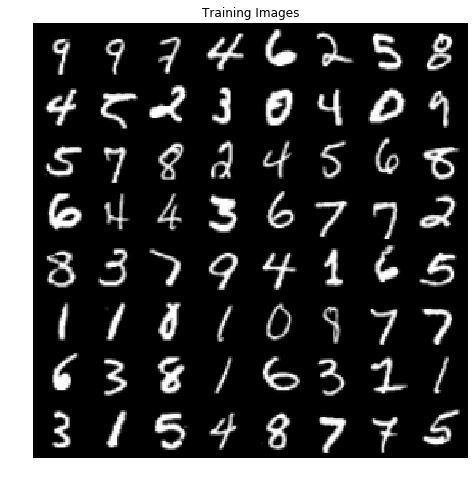

In [8]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## TRAINING BGAN

Now we shall start the training. First we need to create the **Trainer** object. When creating this object all the necessary neural nets and their optimizers get instantiated.

In [9]:
trainer = Trainer(network_config, losses, ncritic=5, epochs=epochs, sample_size=64, device=device)

In [10]:
trainer(dataloader)

Saving Model at './model/gan0.model'


/data/avikpal/miniconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BoundarySeekingLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1 Summary
generator Mean Gradients : 0.10104659697431433
discriminator Mean Gradients : 904155.1795973617
Mean Running Discriminator Loss : 410.93980566121763
Mean Running Generator Loss : 0.08615240997945268
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
generator Mean Gradients : 0.0917528209010618
discriminator Mean Gradients : 508912.41829931387
Mean Running Discriminator Loss : 330.299362311929
Mean Running Generator Loss : 0.13822616737646362
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
generator Mean Gradients : 0.13660389331132433
discriminator Mean Gradients : 365071.02418654336
Mean Running Discriminator Loss : 285.52138703556386
Mean Running Generator Loss : 0.22068778881934328
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
generator Mean Gradients : 0.23496990981

## VISUALIZING THE GENERATED IMAGES

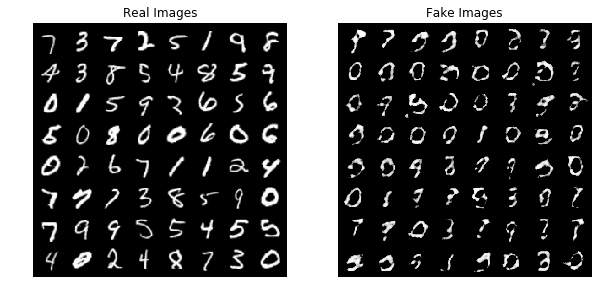

In [11]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, 280)))
plt.show()